# Get Client ID and Secret

In [83]:
import requests
import base64
import warnings
import configparser
warnings.filterwarnings('ignore')

config = configparser.ConfigParser()
config.read('config.ini')

# Replace with your own Client ID and Client Secret
CLIENT_ID = config.get('Credentials', 'CLIENT_ID')
CLIENT_SECRET = config.get('Credentials', 'CLIENT_SECRET')

In [57]:
# Encode the client ID and client secret using Base64
credentials_encoded = f"{CLIENT_ID}:{CLIENT_SECRET}"
credentials_base64 = base64.b64encode(credentials_encoded.encode())

# Requesting the access token from Spotify API
token_url = 'https://accounts.spotify.com/api/token'
headers = {
    'Authorization': f'Basic {credentials_base64.decode()}'
}
payload = {
    'grant_type': 'client_credentials'
}
response = requests.post(token_url, data=payload, headers=headers)

# Check if the access token is obtained successfully
if response.status_code == 200:
    access_token = response.json()['access_token']
    print("Access token obtained successfully.")
else:
    print("Error obtaining access token.")
    exit()


Access token obtained successfully.


# Fetch Music Data for a Playlist 

In [58]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyOAuth

def fetch_playlist_data(playlist_id, access_token):
    # Set up Spotipy with the provided access token
    spotify_client = spotipy.Spotify(auth=access_token)

    # Retrieve tracks from the playlist
    playlist_tracks = spotify_client.playlist_tracks(playlist_id, fields='items(track(id, name, artists, album(id, name)))')

    # Extract relevant information and store it in a list of dictionaries
    music_data = []
    for track_info in playlist_tracks['items']:
        track = track_info['track']
        track_name = track['name']
        artists = ', '.join([artist['name'] for artist in track['artists']])
        album_name = track['album']['name']
        album_id = track['album']['id']
        track_id = track['id']

        # Get audio features for the track
        audio_features = spotify_client.audio_features(track_id)[0] if track_id != 'Not available' else None

        # Get release date of the album
        try:
            album_info = spotify_client.album(album_id) if album_id != 'Not available' else None
            release_date = album_info['release_date'] if album_info else None
        except:
            release_date = None

        # Get popularity of the track
        try:
            track_info = spotify_client.track(track_id) if track_id != 'Not available' else None
            popularity = track_info['popularity'] if track_info else None
        except:
            popularity = None

        # Additional track information
        track_data = {
            'Track Name': track_name,
            'Artists': artists,
            'Album Name': album_name,
            'Album ID': album_id,
            'Track ID': track_id,
            'Popularity': popularity,
            'Release Date': release_date,
            'Duration (ms)': audio_features['duration_ms'] if audio_features else None,
            'Explicit': track_info.get('explicit', None),
            'External URLs': track_info.get('external_urls', {}).get('spotify', None),
            'Danceability': audio_features['danceability'] if audio_features else None,
            'Energy': audio_features['energy'] if audio_features else None,
            'Key': audio_features['key'] if audio_features else None,
            'Loudness': audio_features['loudness'] if audio_features else None,
            'Mode': audio_features['mode'] if audio_features else None,
            'Speechiness': audio_features['speechiness'] if audio_features else None,
            'Acousticness': audio_features['acousticness'] if audio_features else None,
            'Instrumentalness': audio_features['instrumentalness'] if audio_features else None,
            'Liveness': audio_features['liveness'] if audio_features else None,
            'Valence': audio_features['valence'] if audio_features else None,
            'Tempo': audio_features['tempo'] if audio_features else None,
            # Add more attributes as needed
        }

        music_data.append(track_data)

    # Create a pandas DataFrame from the list of dictionaries
    playlist_df = pd.DataFrame(music_data)

    return playlist_df

In [59]:
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyOAuth

# Spotify playlist ID for a trending playlist
playlist_id = '37i9dQZF1DX76Wlfdnj7AP'

# Call the function to retrieve music data from the playlist and store it in a DataFrame
music_data_frame = fetch_playlist_data(playlist_id, access_token)

In [60]:
static_data = pd.read_csv("static_data.csv")

In [61]:
print(music_data_frame.shape)

(100, 21)


In [62]:
music_data_frame = pd.concat([music_data_frame,static_data],ignore_index=True).drop("_id",axis=1)

In [63]:
music_data_frame.shape

(250, 21)

# Storing Data in MongoDB

In [64]:
import pymongo

try: 
    conn = pymongo.MongoClient("localhost", 27017)

    print("Connected successfully!!!") 
except:   
    print("Could not connect to MongoDB") 

Connected successfully!!!


In [65]:
# Connect to MongoDB

db = conn.bhavneet_project
collection = db.music_rec
db.collection.insert_many(music_data_frame.to_dict('records'))

InsertManyResult([ObjectId('6560cef0eca2fc656f5aab24'), ObjectId('6560cef0eca2fc656f5aab25'), ObjectId('6560cef0eca2fc656f5aab26'), ObjectId('6560cef0eca2fc656f5aab27'), ObjectId('6560cef0eca2fc656f5aab28'), ObjectId('6560cef0eca2fc656f5aab29'), ObjectId('6560cef0eca2fc656f5aab2a'), ObjectId('6560cef0eca2fc656f5aab2b'), ObjectId('6560cef0eca2fc656f5aab2c'), ObjectId('6560cef0eca2fc656f5aab2d'), ObjectId('6560cef0eca2fc656f5aab2e'), ObjectId('6560cef0eca2fc656f5aab2f'), ObjectId('6560cef0eca2fc656f5aab30'), ObjectId('6560cef0eca2fc656f5aab31'), ObjectId('6560cef0eca2fc656f5aab32'), ObjectId('6560cef0eca2fc656f5aab33'), ObjectId('6560cef0eca2fc656f5aab34'), ObjectId('6560cef0eca2fc656f5aab35'), ObjectId('6560cef0eca2fc656f5aab36'), ObjectId('6560cef0eca2fc656f5aab37'), ObjectId('6560cef0eca2fc656f5aab38'), ObjectId('6560cef0eca2fc656f5aab39'), ObjectId('6560cef0eca2fc656f5aab3a'), ObjectId('6560cef0eca2fc656f5aab3b'), ObjectId('6560cef0eca2fc656f5aab3c'), ObjectId('6560cef0eca2fc656f5aab

# Fetching Data from MongoDB

In [66]:
# Query data from MongoDB
db = conn.bhavneet_project
collection = db.music_rec
cursor = collection.find({})
data = list(cursor)

# Create a DataFrame from the MongoDB data
music_data_frame = pd.DataFrame(data)

# Close the MongoDB connection
conn.close()

# Display the DataFrame
print(music_data_frame)

                         _id                   Track Name  \
0   655e4b9a2cae47e274a253ef                        Prada   
1   655e4b9a2cae47e274a253f0                     fukumean   
2   655e4b9a2cae47e274a253f1           IDGAF (feat. Yeat)   
3   655e4b9a2cae47e274a253f2              I'm Good (Blue)   
4   655e4b9a2cae47e274a253f3              Me Porto Bonito   
..                       ...                          ...   
95  655e4b9a2cae47e274a2544e                All By Myself   
96  655e4b9a2cae47e274a2544f           Red Ruby Da Sleeze   
97  655e4b9a2cae47e274a25450        Rainfall (Praise You)   
98  655e4b9a2cae47e274a25451                       LOKERA   
99  655e4b9a2cae47e274a25452  pushin P (feat. Young Thug)   

                          Artists             Album Name  \
0     cassö, RAYE, D-Block Europe                  Prada   
1                           Gunna       a Gift & a Curse   
2                     Drake, Yeat       For All The Dogs   
3        David Guetta, Bebe

In [67]:
print(music_data_frame.isnull().sum())

_id                 0
Track Name          0
Artists             0
Album Name          0
Album ID            0
Track ID            0
Popularity          0
Release Date        0
Duration (ms)       0
Explicit            0
External URLs       0
Danceability        0
Energy              0
Key                 0
Loudness            0
Mode                0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
dtype: int64


# Data Visualization

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

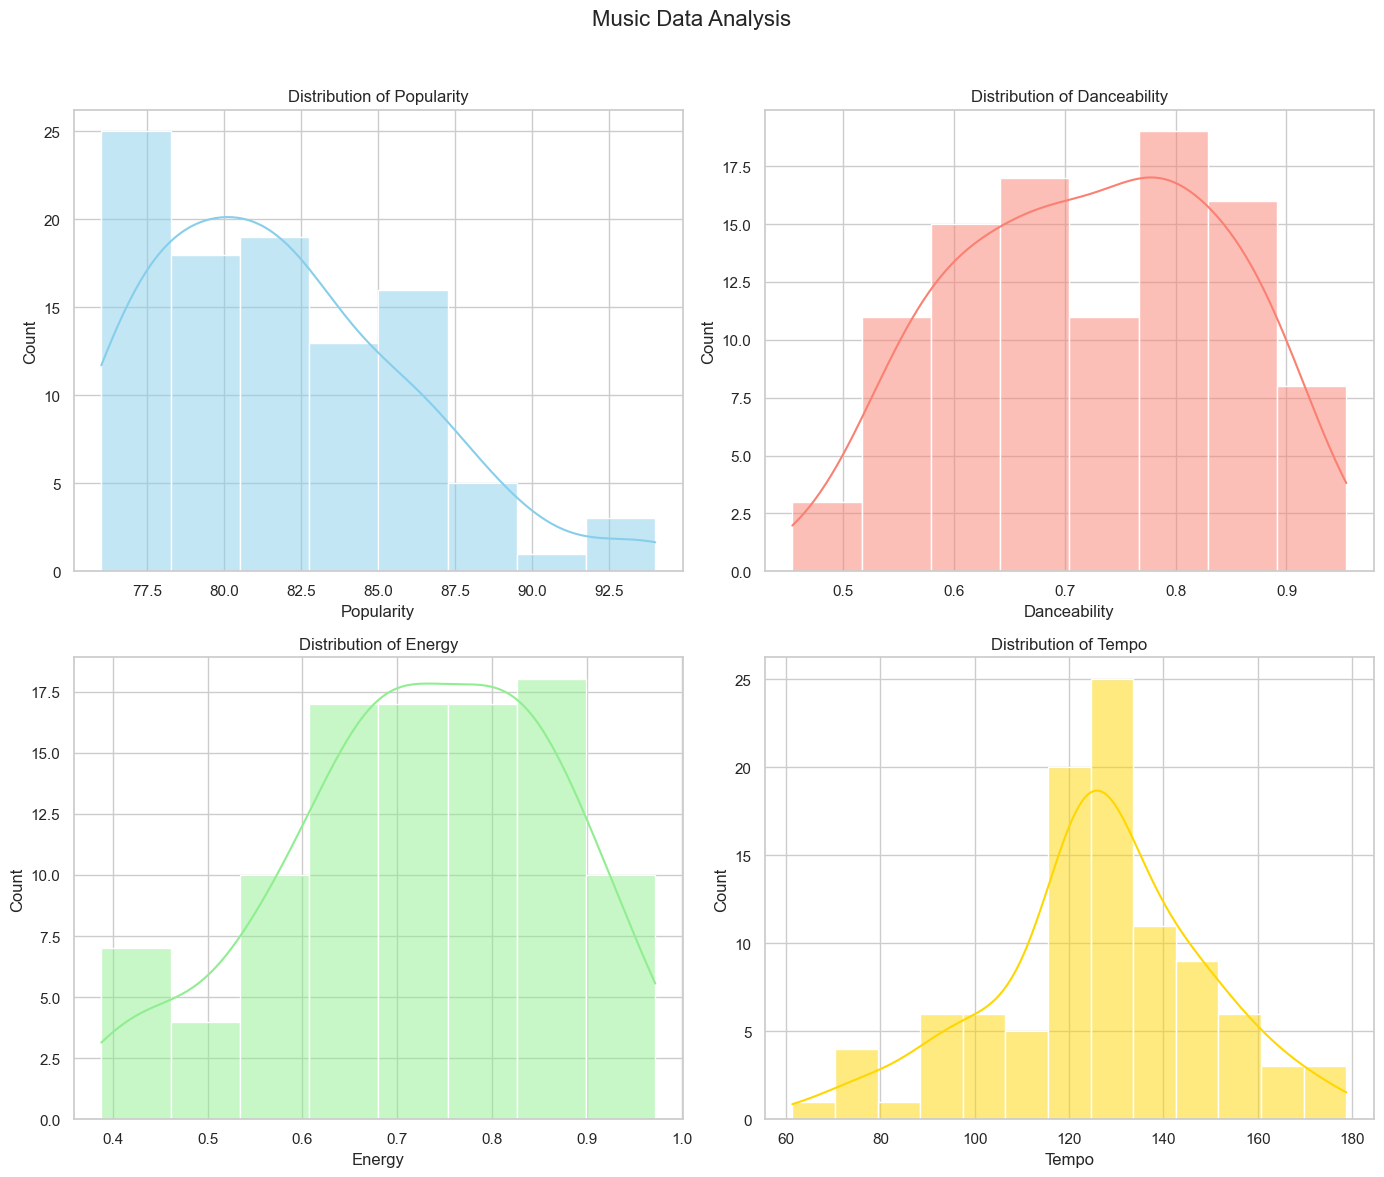

In [69]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
fig.suptitle('Music Data Analysis', fontsize=16)

# Univariate Analysis - Histograms
sns.histplot(music_data_frame['Popularity'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of Popularity')

sns.histplot(music_data_frame['Danceability'], kde=True, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Distribution of Danceability')

sns.histplot(music_data_frame['Energy'], kde=True, ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Distribution of Energy')

sns.histplot(music_data_frame['Tempo'], kde=True, ax=axes[1,1], color='gold')
axes[1, 1].set_title('Distribution of Tempo')

plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

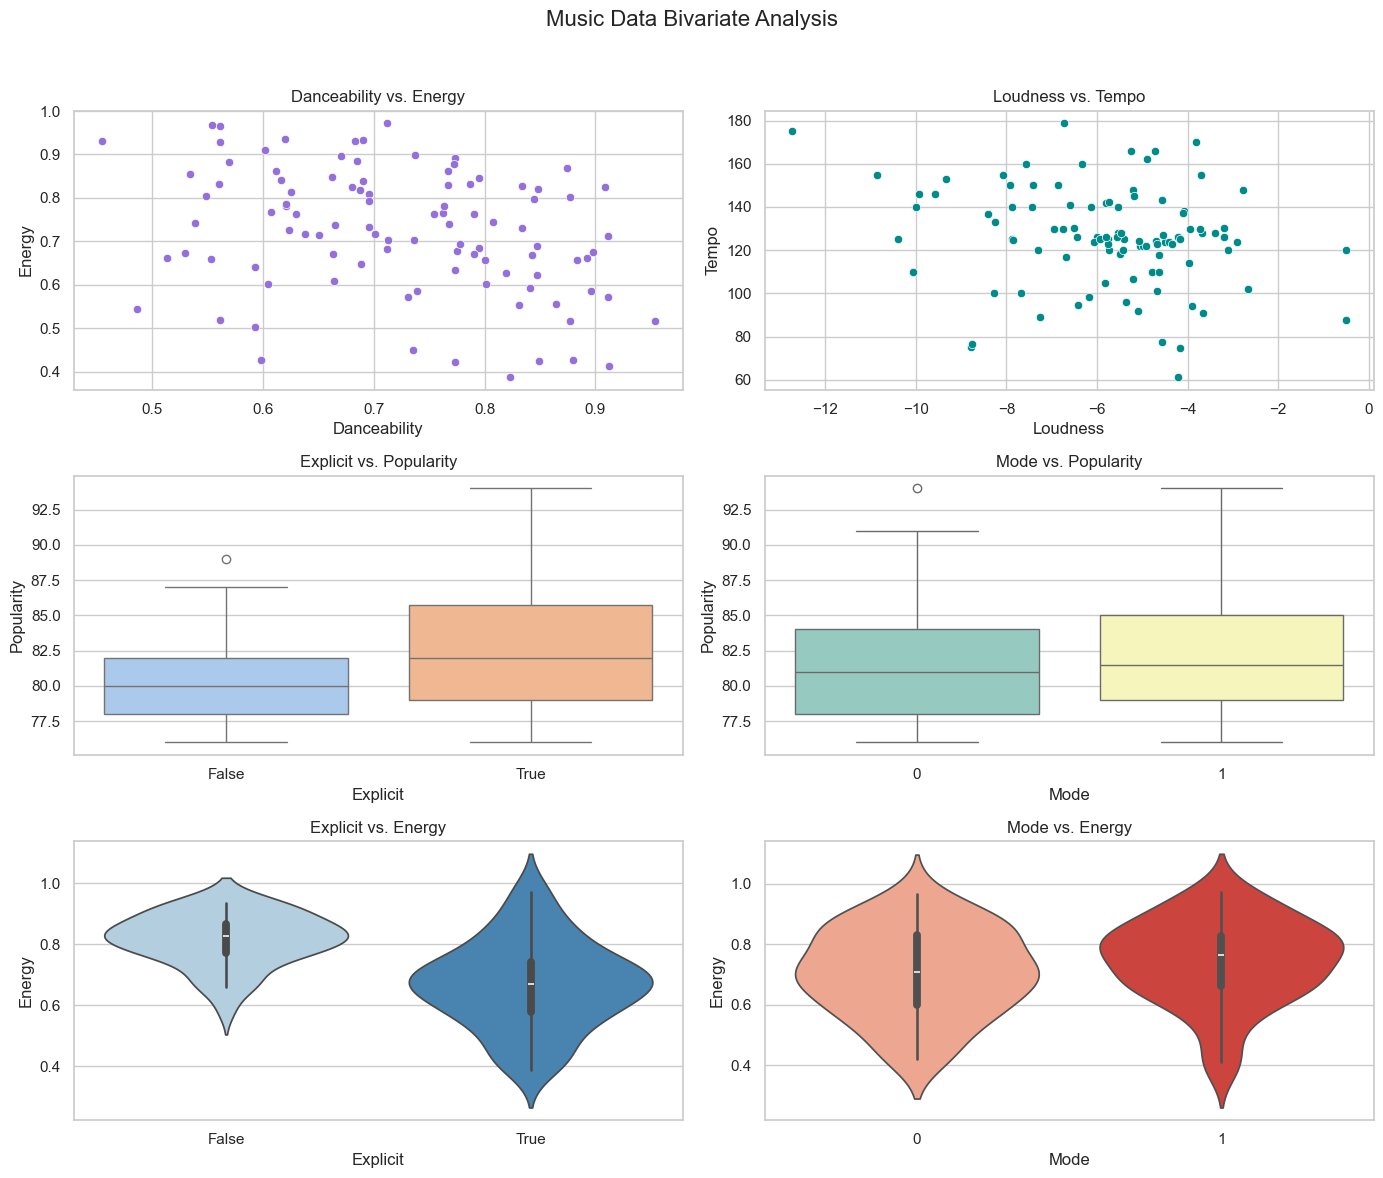

In [70]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
fig.suptitle('Music Data Bivariate Analysis', fontsize=16)

# Bivariate Analysis - Scatter Plots
sns.scatterplot(x='Danceability', y='Energy', data=music_data_frame, ax=axes[0, 0], color='mediumpurple')
axes[0, 0].set_title('Danceability vs. Energy')

sns.scatterplot(x='Loudness', y='Tempo', data=music_data_frame, ax=axes[0, 1], color='darkcyan')
axes[0, 1].set_title('Loudness vs. Tempo')

# Bivariate Analysis - Box Plots
sns.boxplot(x='Explicit', y='Popularity', data=music_data_frame, ax=axes[1, 0], palette='pastel')
axes[1, 0].set_title('Explicit vs. Popularity')

sns.boxplot(x='Mode', y='Popularity', data=music_data_frame, ax=axes[1, 1], palette='Set3')
axes[1, 1].set_title('Mode vs. Popularity')

# Bivariate Analysis - Violin Plots
sns.violinplot(x='Explicit', y='Energy', data=music_data_frame, ax=axes[2, 0], palette='Blues')
axes[2, 0].set_title('Explicit vs. Energy')

sns.violinplot(x='Mode', y='Energy', data=music_data_frame, ax=axes[2, 1], palette='Reds')
axes[2, 1].set_title('Mode vs. Energy')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

# Modelling

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity

data = music_data_frame

In [77]:
# Function to calculate weighted popularity scores based on release date
def calculate_weighted_popularity(release_date_str):
    # Convert the release date string to a datetime object
    release_date = datetime.strptime(release_date_str, '%Y-%m-%d')

    # Calculate the time span between the release date and today's date
    time_span = datetime.now() - release_date

    # Calculate the weighted popularity score based on time span (e.g., more recent releases have higher weight)
    weight = 1 / (time_span.days + 1)
    return weight


In [78]:
# Normalize the music features using Min-Max scaling
feature_scaler = MinMaxScaler()
selected_features = music_data_frame[['Danceability', 'Energy', 'Key', 
                              'Loudness', 'Mode', 'Speechiness', 'Acousticness',
                              'Instrumentalness', 'Liveness', 'Valence', 'Tempo']].values
normalized_features = feature_scaler.fit_transform(selected_features)


In [79]:
# A function to get content-based recommendations based on music features
def get_content_based_recommendations(input_track_name, num_recommendations=5):
    if input_track_name not in music_data_frame['Track Name'].values:
        print(f"'{input_track_name}' not found in the dataset. Please enter a valid track name.")
        return

    # Get the index of the input track in the music DataFrame
    input_track_index = music_data_frame[music_data_frame['Track Name'] == input_track_name].index[0]

    # Calculate the similarity scores based on normalized music features (cosine similarity)
    similarity_scores = cosine_similarity([normalized_features[input_track_index]], normalized_features)

    # Get the indices of the most similar tracks
    similar_track_indices = similarity_scores.argsort()[0][::-1][1:num_recommendations + 1]

    # Get the details of the most similar tracks based on content-based filtering
    content_based_recommendations = music_data_frame.iloc[similar_track_indices][['Track Name', 'Artists', 'Album Name', 'Release Date', 'Popularity']]

    return content_based_recommendations


In [80]:
# A function to get hybrid recommendations based on weighted popularity
def get_hybrid_recommendations(input_track_name, num_recommendations=5, alpha=0.5):
    if input_track_name not in music_data_frame['Track Name'].values:
        print(f"'{input_track_name}' not found in the dataset. Please enter a valid track name.")
        return

    # Get content-based recommendations
    content_based_rec = get_content_based_recommendations(input_track_name, num_recommendations)

    # Get the popularity score of the input track
    popularity_score = music_data_frame.loc[music_data_frame['Track Name'] == input_track_name, 'Popularity'].values[0]

    # Calculate the weighted popularity score
    weighted_popularity_score = popularity_score * calculate_weighted_popularity(music_data_frame.loc[music_data_frame['Track Name'] == input_track_name, 'Release Date'].values[0])

    # Combine content-based and popularity-based recommendations based on weighted popularity
    hybrid_recommendations = content_based_rec
    hybrid = pd.DataFrame([{
        'Track Name': "ASDS",
        'Artists': music_data_frame[music_data_frame['Track Name'] == input_track_name]['Artists'].values[0],
        'Album Name': music_data_frame[music_data_frame['Track Name'] == input_track_name]['Album Name'].values[0],
        'Release Date': music_data_frame[music_data_frame['Track Name'] == input_track_name]['Release Date'].values[0],
        'Popularity': 10
    }])
    print(hybrid)
    hybrid_recommendations = pd.concat([hybrid, hybrid_recommendations])

    # Sort the hybrid recommendations based on weighted popularity score
    hybrid_recommendations = hybrid_recommendations.sort_values(by='Popularity', ascending=False)

    # Remove the input track from the recommendations
    hybrid_recommendations = hybrid_recommendations[hybrid_recommendations['Track Name'] != input_track_name]

    return hybrid_recommendations


# Get Recommendation

In [82]:
input_song_name = "I'm Good (Blue)"
recommendations = get_hybrid_recommendations(input_song_name, num_recommendations=5)
print(f"Hybrid recommended songs for '{input_song_name}':")
print(recommendations)

  Track Name                   Artists       Album Name Release Date  \
0       ASDS  David Guetta, Bebe Rexha  I'm Good (Blue)   2022-08-26   

   Popularity  
0          10  
Hybrid recommended songs for 'I'm Good (Blue)':
                    Track Name                                     Artists  \
5   FE!N (feat. Playboi Carti)                 Travis Scott, Playboi Carti   
57                Call It Love                     Felix Jaehn, Ray Dalton   
70                       REACT  Switch Disco, Ella Henderson, Robert Miles   
80                        BOTH                      Tiësto, 21 Savage, BIA   
84               Where You Are                          John Summit, Hayla   
0                         ASDS                    David Guetta, Bebe Rexha   

         Album Name Release Date  Popularity  
5            UTOPIA   2023-07-28          89  
57     Call It Love   2022-09-16          80  
70            REACT   2023-01-13          79  
80             BOTH   2023-08-29        